# Science narrative

In [ ]:
# mini-source control: Last copied 29-SEP-2020: to tilt*, chlorophyll*, rca*, argo*
#                      last revised 09-OCT-2020
import os, sys, time, glob

from IPython.display import clear_output             # use inside loop with clear_output(wait = True) followed by print(i)
import warnings                                      # use with warnings.filterwarnings('ignore') or 'once'

home_dir = os.getenv("HOME")
this_dir = home_dir + '/chlorophyll/'
data_dir = '/data/'
data1_dir = '/data1'

from matplotlib import pyplot as plt
from matplotlib import colors as mplcolors
import numpy as np, pandas as pd, xarray as xr
from numpy import datetime64 as dt64, timedelta64 as td64

def doy(theDatetime): return 1 + int((theDatetime - dt64(str(theDatetime)[0:4] + '-01-01')) / td64(1, 'D')) # 1, 2, .... , 365, [366]
def dt64_from_doy(year, doy): return dt64(str(year) + '-01-01') + td64(doy-1, 'D')
def day_of_month_to_string(d): return str(d) if d > 9 else '0' + str(d)

print('\nJupyter Notebook running Python {}'.format(sys.version_info[0]))

## Introduction to the Pangeo Core

From some encouragement I am writing out this *process* notebook: On 
learning XArray, Dask and Intake-STAC. These (and implicitly Python) are 
the Scientist-side technical core of the Pangeo toolkit. 

## Alternative paths for those in a hurry

Documentation abounds but can be a bit light on connectivity and context. 
Here are some alternative paths in this vein. 
This notebook presents in a rather leisurely fashion. 


* The [Pangeo Outreach Education Training repository](https://github.com/pangeo-data/education-material) is a guide to guides, often terse
* Jake VanderPlas' [Python data science handbook](https://jakevdp.github.io/PythonDataScienceHandbook): Free, excellent, no catch
  * Chapter subjects: **IPython**, **numpy**, **pandas**, **matplotlib**, **machine learning**
* An [intro to xarray repo](https://github.com/coecms-training/introduction_to_xarray)
* A corresponding [eight video YouTube series](https://youtu.be/zoB54IpofYA)



## Motivation for this repo

* Geoscientists self-teach Python and its libraries: Numpy, XArray, and so on
* We have a bias towards documentation at times, that it 'ought to be sufficient' 
* Result: The *learner-scientist* can get stuck when documentation is insufficient
  * This can be discouraging
  * When each surmounted roadblock is followed by another: success can feel elusive
* Knowledge bases such as stack overflow can be immensely helpful at times
* Suggestions...
  * Develop a working understanding of three related things (and there is no way around
it, it will take some time to internalize): The **XArray data model**, the associated 
syntax and a dozen-or-so methods available to manipulate, subset, reduce and visualize 
your data.
  * If a solution you develop seems unnecessarily complicated: There is often an easier way.
    * Example: If the task is to down-sample a time-series Dataset and you begin writing a for-loop: 
    Find the `.resample()` method and use that instead. 


## Why coastal ocean productivity and land ice motion?

First answer: Data are readily available for making progress and these are interesting topics.

Extended answer part one: Biogeochemistry is concerned with earth-scale reserves and transport of carbon. 
Coastal oceans are highly productive (phytoplankton biomass) and complex. 

Extended answer part two: Glaciers are retreating
transforming their cathment basins into fast direct conduits of fresh water. 
This change in annual freshwater circulation is connected to coastal marine productivity. 


## Background on the Regional Cabled Array 


There is an ocean observatory supporting dozens 
of sensors emplaced: Both along the sea floor and within the water column. 
The observatory consists of multiple sites located
along the continental margin in the northeast 
Pacific, specifically off the coast of Oregon state in the US. 
The observatory -- called the Regional Cabled Array -- measures 
pH and salinity and 
temperature and chlorphyll and other parameters about 
once per second, so each sensor stream might produce 31 
million samples per year. The Regional Cabled Array has been 
operating since 2014.


## Background on land ice velocity and the GOLIVE project


The second research challenge addressed here
uses data from a LANDSAT-derived product called **GoLive**. This is
a time series data collection of the speeds of all the glaciers 
on earth measured 
every few days for close to two decades.
The challenge is to scan the data for both trends and anomalies. 
We are interested in understanding and predicting how glacier transport and
glacial extent will change in coming decades as climate response to human 
activity continues to accelerate.

## What drives coastal ocean productivity?

`Productivity` concerns the proliferation of life in a biome. In the ocean 
it is often shorthand for primary productivity by plankton
measured in chlorophyll mass per ocean water volume at a given
time and depth. 


Coastal / shelf waters are many times more productive compared to
the deep ocean. Two contributing factors are thought to be freshwater run-off from land 
and upwelling of deep water off the continental shelf. For example fresh water from the 
Columbia River might carry chromophoric dissolved
organic matter (cdom) produced by the decay of land vegetation into coastal waters.
There it might supply important nutrients that drive up coastal ocean productivity.
An increase in CDOM and a decrease in surface water salinity should in principle be 
observable by the Regional Cabled Array. Upwelling events should also produce
characteristic signals in the data.

## Data analysis charter

So... where to begin? I take a retrograde approach: Start with the data and work backwards, 
in a sense, to productivity. I begin with data from a *platform* (in fact a *profiler*) 
that rises and falls through the upper 200 meters of the water column about nine times 
per day. Break that down into all of the *instruments* carrying *sensors* producing 
data *streams* and so we have a complicated task.


There is an unfortunate but unavoidable aspect of interpreting sensor data streams: 
Sometimes the sensor reflects the state of the ocean water accurately and sometimes 
it does not. Sensors can produce degraded or meaningless data; so the data 
analysis includes measures 
to establish a degree of confidence in our conclusions. As a first step 
to this end we can consider 
[relative standard deviation](https://en.wikipedia.org/wiki/Coefficient_of_variation).



The sampling rate of these sensor is about one sample per second. Some
operate episodically while others produce continuous data streams. Because the ocean is vertically 
stratified with depth corresponding to light (available energy) the first part of the program
is to sort and visualize sensor data streams by *depth* at fairly coarse resolution -- say 
1 to 10 meters -- by down-sampling the stream data in time. The sensors move through 
the water column slowly so aggregating by time -- say a minute of data -- and
retaining both mean and standard deviation reduces both sensor noise and data volume
while providing a view of sensor veracity.


Beyond down-sampling data streams we would also like to capture transients and 
signal structure of interest, either as individual events or taken
as statistical distributions. For example it is common to find a maximum 
chlorophyll concentration at some depth beneath the ocean surface that 
could be recorded as a *derived* time-series signal. 

# Cutoff

This is the end of the science text so what follows goes to a separate notebook on learning XArray and Dask...


## Methods of debugging the process

This is a fragment... the idea being to illustrate reducing a problematical
dataset in the time axis to debug "apparent kernel hang".


There are two goals of the "in flight" process of creating the chlorophyll
notebook. Two goals, that is, around bringing together data streams from 
multiple sensors scattered across eight or nine instruments. The first is to
reconcile everything to the same sample metronome. The second is to
reduce both noise and data volume by resampling the data, hopefully without
suppressing transients of real interest. 


The two XArray methods that correspond to these tasks are `.merge()` and
`.resample()`. But which to do first? Intuitively it would make sense to
`resample` the data first for each Dataset. So the fluorometer would be 
resampled and the CTD would be resampled independently; and then once 
those data volumes have been reduced by a factor of 60 they could be 
easily merged, particularly having been converted to the same cadence
of time stamps. 

## Reduction by mean and standard deviation

In cases where the sensor is noisy and the sampling rate is high (for example one 
sample per second) we have the option to reduce noise by averaging. This presumes 
that the sensor depth and elapsed time change little over the averaging interval; 
suppose about one meter and one minute. 


If as often appears to be the case the data are noisy then an average value 
might mask that; so it will also be a useful idea to calculate the standard 
deviation of the averaged samples. We have a really useful resource in XArray
to this end, the `.resample()` method which essentially *expects* a second
method appended that guides *how* the resampling is done. We have a Dataset
`ds` and...

```
ds_mean = ds.resample(time='1Min').mean()
ds_std  = ds.resample(time='1Min').std()
```

The data are time-series and the `resample()` method expects a resampling 
dimension. Time is an expected pattern of course so a system of time strings
was developed. In this case the `Min` qualifier indicates minutes so `'1Min'`
with the trailing `.mean()` translates to "**Resample this Dataset across 
all of its Coordinates and Data Variables to a regular series of time 
stamps: One per minute.**"


The second line of code acts as a data quality metric since each Data variable 
and Coordinate resampled by the standard deviation method `.std()` will have
values indicating the relative noisiness of the data averaged over that interval. 
Temperature is fairly easy to measure consistently and we expect that will be 
reflected in the `ds_std.seawater_temperature` DataArray. In contrast the
fluorometric chlorophyll signal in `ds_std` should be
very noisy. 

## Jupyter notebooks: Three desired outcomes

The goal here is to avoid going through the various learning curves to produce an 
end result that "gleams with perfection" with no hint as to how it was produced. 
Furthermore there is nothing magical about binning results in ten meter depth intervals. 
What if you want 20 meters? Or 2 meters? My arbitrary choices should not 
influence another person interested using these results.  So with the data we 
bring along machinery that pulls in the source data and builds the resultant data. 
This makes the steps reproducible; a new dataset is at least hypothetically
easy to generate with minimal effort. There are two items of value: Data and 
machinery. The third item of value is the record of the learning process. 


> Definitive example: Each instrument has a number of sensors which produce data 
streams. The spectrophotometer produces two streams -- absorbance and attenuation --
at a rate of about 3 samples per second. Each sample is about 80 values across the
optical spectrum... left off here... but it would be good to point out that 
misunderstanding the timing led to incorrect use of .resample().mean() which was
applied at regular time intervals rather than when the sensor was actually on. 



Python, XArray and Dask were developed to work well together and in many cases to
speed up processing time on large multi-dimensional datasets. As the end goal is for
the results to be openly discoverable there is a strong case for learning
and using Intake-STAC as a last piece of the machinery; but there is a ways to go
with the first three before arriving at that technology. 


Now what actually happened was I started with an instrument with three sensors called a 
fluorometer. The three sensors measure via fluorescence an estimate of chlorophyll in 
the water (with no way to resolve its constituency; just 'how much is there') as well as
concentrations of color-present dissolved organic matter (cdom) and particles in general
(via light backscatter). It took several days to figure out how to use a data-ordering
system that takes advantage of partially built infrastructure, moving that forward to
an interactive Python package called "yodapy" (for **Y**our **O**cean **Da**ta **Py**thon
package). And the only reason I was able to use this effectively *after* several
days of struggling to get it working is because I know and can speak with the 
Developer of code. So unless you know him too I'm at a distinct advantage, and the point
here is that I *shouldn't* be nor do I *want* to be at an advantage. 


So now I have the data for several weeks. But I want to have the data from 2014 to 2020. 
I take as an intermediate goal just the year 2019. I can order this data but it arrives
as multiple files; and each one is ordered not by time but by "observation number" with 
*time* inherently a dependent coordinate. So now I need to swap time in as the 
independent dimension/coordinate so that I can order these multiple files into a 
single Dataset.

## On data provisioning

 * These notebooks describe how to get data from scratch
 * This data is kept outside of the repo but in the Pangeo working environment
 * To make this easier to access we have a **Load** mechanism
 * ...or we will once I build it

## First pass: What is XArray?

XArray precedes Dask; and is built upon pandas and NumPy. 


* Why do I need it?
* How is it going to help?
* What does it do?


The following steps 
require a few hours to go through; plus additional time spent internalizing
the details, ideally by working your own examples. This is the quickest means 
I am aware of for building XArray skills. Dask is covered later.


* Clone [this repository](https://github.com/coecms-training/introduction_to_xarray).
* Watch and work through the accompanying [8-video YouTube tutorial](https://youtu.be/zoB54IpofYA)
* For backing skills with pandas: Work through chapter 3 of the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/)

## First pass: What is Dask?

Dask is two things: Dynamic task scheduling and Big data (out-of-memory) collections. 


My problem with this is that it begins several layers deep in terminology I do not understand. So I'm going to go to some pains to unpack that short definition. Starting with *out-of-memory* which means *the data 
do not fit in memory* and must be periodically brought in from storage in pieces to reach an end result
*as if* it all fit into memory. 


...mumble mumble reads some more...


Ah, ok. Dask is a *task scheduler* that coordinates and speeds up large computations. 
Some of what Dask is good at happens "behind the scenes" in XAarray; and otherwise
Dask is front-and-center in its own right. But this is a bit vague so really what we
need is a narrative-tutorial to follow that will give us a starting point. Let's cut to 
[Ryan's 2018 tutorial](https://rabernat.github.io/research_computing_2018/dask-for-parallel-computing-and-big-data.html). 

In [1]:
import numpy as np                  # cutting and pasting from the tutorial
shape = (1000, 4000)                # a tuple
ones_np = np.ones(shape)            # four million ones
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [2]:
ones_np.nbytes / 1e6         # 32 MBytes as claimed

32.0

In [3]:
import dask.array as da
ones = da.ones(shape)         # I was promised this would throw an error... but it does not

In [4]:
ones                          # No doubt dask has evolved since 7-NOV-2018

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

In [5]:
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)          # Now providing some chunking guidance
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [6]:
%%time

ones.compute()

CPU times: user 24.6 ms, sys: 1.22 ms, total: 25.8 ms
Wall time: 17.6 ms


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

Solving environment: ...working... done

# All requested packages already installed.



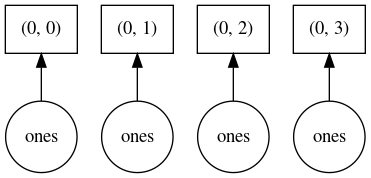

In [7]:
# This magical double-install is a necessary prerequisite for seeing Dask graphs
#   The -y -q means "answer yes to dialogs" and "be reasonably quiet on the output"
!conda install graphviz -y -q
!pip install graphviz

ones.visualize()

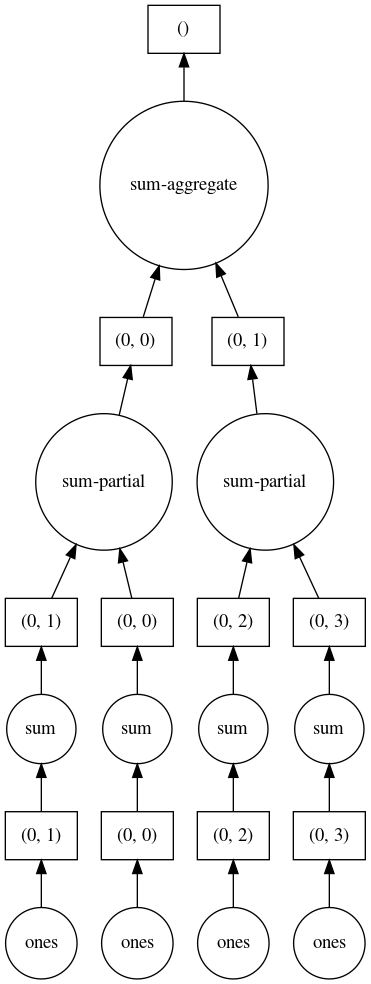

In [8]:
sum_of_ones = ones.sum()
sum_of_ones.visualize()

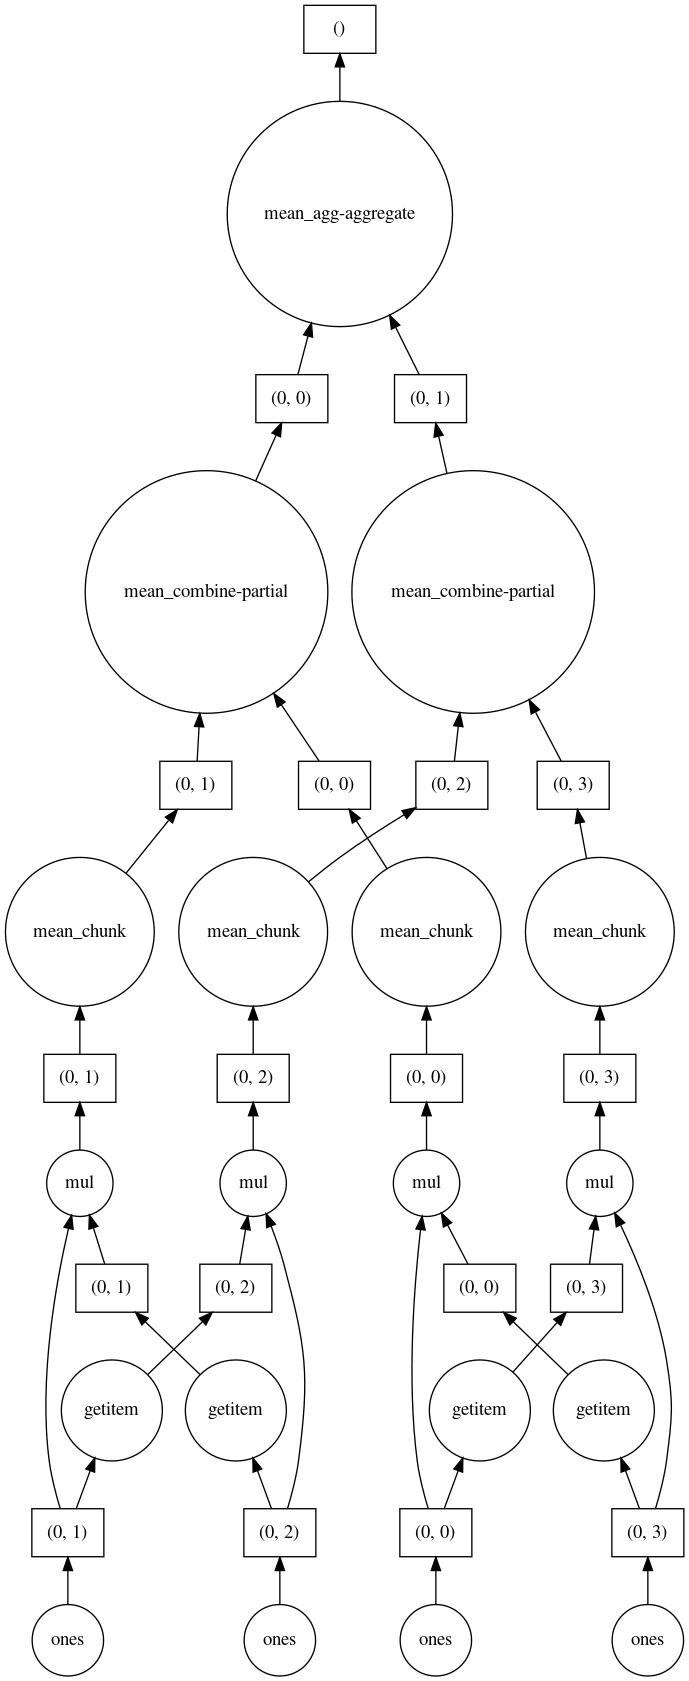

In [9]:
fancy_calculation = (ones * ones[::-1, ::-1]).mean()
fancy_calculation.visualize()                            # pretty cool

## Pause to summarize the Dask tutorial so far

This has given me the jump start I wanted on Dask. I get the idea about *Deus ex Machina* chunking, 
about out-of-memory processing, and how Dask generates internal Directed Acyclic Task Graphs that 
get the work done. We see the game plan using `.visualize()` and we don't actually do the work
of the calculation until we need the results. Super!


I would like to complete this tutorial to get a little further insight into how XArray factors
in. I will skip over the section about "making the test dataset really big" and "invoking kubernetes". 
So I will pick up with using `wget` to pull in a dataset and the subsequent analysis to finish up. 

## `wget` *AVISO 2015* data, follow Ryan's analysis

In [20]:
! wget http://www.ldeo.columbia.edu/~rpa/aviso_madt_2015.tar.gz

--2020-03-17 01:28:17--  http://www.ldeo.columbia.edu/~rpa/aviso_madt_2015.tar.gz
Resolving www.ldeo.columbia.edu (www.ldeo.columbia.edu)... 129.236.14.15
Connecting to www.ldeo.columbia.edu (www.ldeo.columbia.edu)|129.236.14.15|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.ldeo.columbia.edu/~rpa/aviso_madt_2015.tar.gz [following]
--2020-03-17 01:28:17--  https://www.ldeo.columbia.edu/~rpa/aviso_madt_2015.tar.gz
Connecting to www.ldeo.columbia.edu (www.ldeo.columbia.edu)|129.236.14.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494834680 (472M) [application/x-gzip]
Saving to: ‘aviso_madt_2015.tar.gz’

aviso_madt_2015.tar 100%[===================>] 471.91M  23.2MB/s    in 21s     

2020-03-17 01:28:39 (22.9 MB/s) - ‘aviso_madt_2015.tar.gz’ saved [494834680/494834680]



In [24]:
# At this point I used the terminal to move the .tar.gz file to ~/data/aviso
#   I then ran tar -xvzf aviso_madt_2015.tar.gz to break the data files out into subdirectory '2015'
!ls ~/data/aviso/2015 | wc -l

365


In [28]:
%%time

# one data file per day for a year, good start
# Skipping the explanatory for xr.open_dataset() let's cut to the chase and open all 365 data files.
#   Notice I continue to accommodate their location in ~/data/aviso; this time with an explicit path.
import xarray as xr
ds = xr.open_mfdataset('/home/jovyan/data/aviso/2015/*.nc', combine='by_coords')
ds

CPU times: user 4.8 s, sys: 35.5 ms, total: 4.83 s
Wall time: 11.7 s


<xarray.Dataset>
Dimensions:   (lat: 720, lon: 1440, nv: 2, time: 365)
Coordinates:
  * lat       (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * nv        (nv) int32 0 1
  * time      (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-31
Data variables:
    lat_bnds  (time, lat, nv) float32 dask.array<shape=(365, 720, 2), chunksize=(1, 720, 2)>
    lon_bnds  (time, lon, nv) float32 dask.array<shape=(365, 1440, 2), chunksize=(1, 1440, 2)>
    crs       (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
    adt       (time, lat, lon) float64 dask.array<shape=(365, 720, 1440), chunksize=(1, 720, 1440)>
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Absolute Dynamic Topography
    contact:                         aviso@

In [39]:
# That is one dataset called `ds`, pulling together 365 files, about 3 GB, no computations yet.
# 
#   Notice that I used a qualifier keyword not found in the original tutorial. This is an example
#   of how XArray evolves and sometimes deprecates / abandons earlier syntax. We now explicitly 
#   tell XArray to combine the datasets along the coordinate dimension with: combine='by_coords'.
#
# 
#   Notice also that the Data variables in the Dataset ds are Dask arrays with auto-determined
#   chunk shapes. 
# 
#   Next we pull Absolute Dynamic Topography from the ds into a DataArray called ssh.
#     This has its own metadata (grid_mapping etcetera) that does not appear in the ds attributes.

ssh = ds.adt
ssh                           # Notice the order of indices maps to time, then lat, then lon
                              # This means that if you index just the first you are choosing a time

<xarray.DataArray 'adt' (time: 365, lat: 720, lon: 1440)>
dask.array<shape=(365, 720, 1440), dtype=float64, chunksize=(1, 720, 1440)>
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-31
Attributes:
    grid_mapping:   crs
    long_name:      Absolute Dynamic Topography
    standard_name:  sea_surface_height_above_geoid
    units:          m

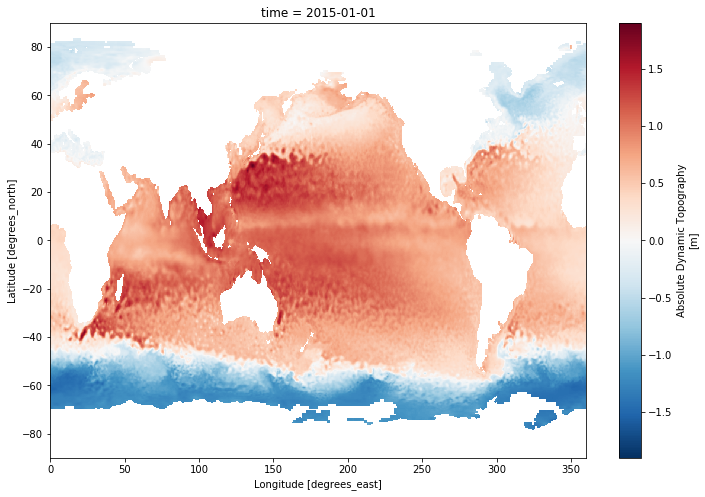

In [40]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)
ssh[0].plot()

In [45]:
%%time
ssh_2015_mean = ssh.mean(dim='time')
ssh_2015_mean.load()

CPU times: user 21.5 s, sys: 3.83 s, total: 25.3 s
Wall time: 8.06 s


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'adt' (lat: 720, lon: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875

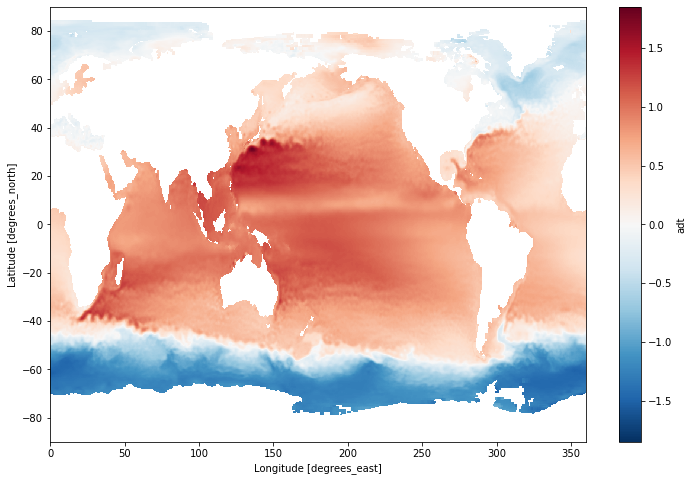

In [46]:
ssh_2015_mean.plot()

In [47]:
%%time

ssh_anom = ssh - ssh_2015_mean
ssh_variance_lonmean = (ssh_anom**2).mean(dim=('lon', 'time'))

CPU times: user 29 ms, sys: 16 µs, total: 29 ms
Wall time: 27.8 ms


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


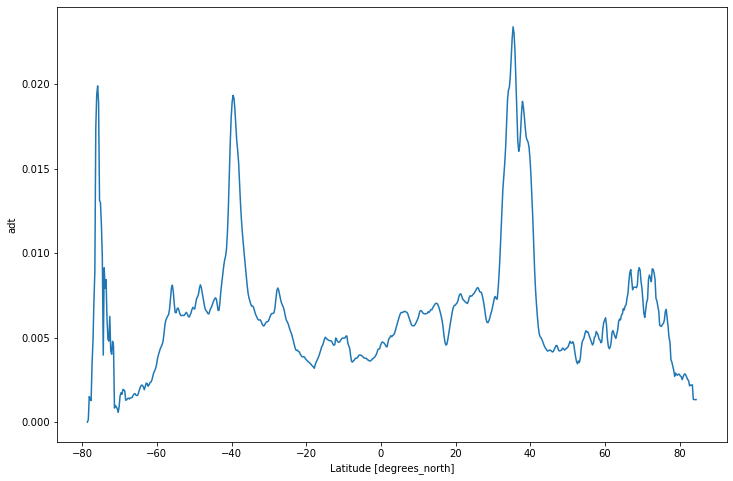

In [48]:
ssh_variance_lonmean.plot()

In [49]:
%%time

weight = np.cos(np.deg2rad(ds.lat))
weight /= weight.mean()

CPU times: user 1.93 ms, sys: 237 µs, total: 2.17 ms
Wall time: 1.81 ms


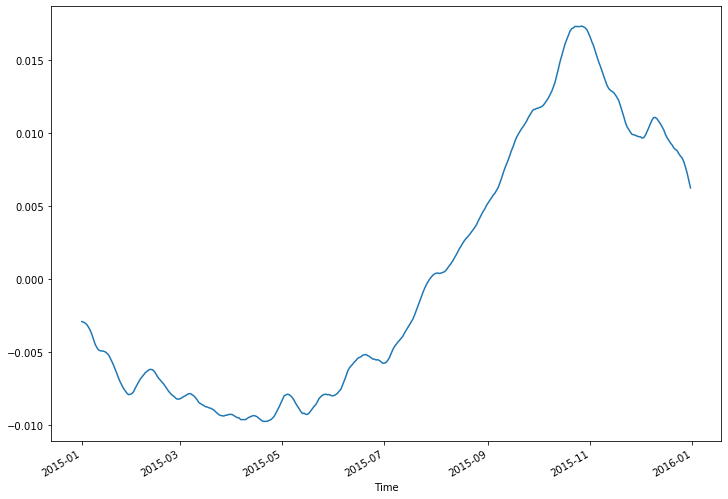

In [50]:
(ssh_anom * weight).mean(dim=('lon', 'lat')).plot()

## Wrap up this first pass at XArray and Dask

* **XArray** is an advance that expands upon **pandas** in context of a geospatial data model.
* **XArray** will fall over on sufficiently large datasets; enter **Dask**
* **Dask** contributes to this 'will not fit in memory' issue with the chunk construct, with task graphs and with lazy execution


There is some good guidance online about chunking; which seems to be something of an art. 
There are still as well many open questions before this goes from *amazement* to *working tool*.


Approach: From a (possibly Pangeo) Jupyter Lab environment clone 
[the dask tutorial repo](https://github.com/dask/dask-tutorial).


The [YouTube workshop video from 2018](https://youtu.be/mqdglv9GnM8) runs through this tutorial. 


Unfortunately some questions are inaudible so it can be difficult to follow in places. 
Also there is very little motivation in the exposition. One key idea that goes by 
rather quickly is "in memory / not in memory". 

## What is Intake-STAC?

* Why?
* How?
* What? 

Anticipating where thsi is going...

## What is XPublish?

* Why?
* How? 
* What?

## Second pass on XArray: spadework

I have two *actual research* objectives that should ideally result in papers. I'll present these as 
short abstracts. 

* Temperate glaciers are thinning and receding. They also surge episodically, essentially 
decoupling from the glacial bed and moving quickly. We have global remote sensing observations
of glaciers back to 1991 (and earlier) available. This work characterizes quiescent glacier
behavior and capture surge events over a thirty year interval.*


* The ocean water column is observed at high resolution at three locations in the northeast
Pacific by the Regional Cabled Array, an observatory that is a major component of Ocean Observations
Initiative. This work characterizes means and variances of the ocean as observed by RCA sensors
in both time and depth. It also generates a separate dataset flagging anomalies in an idealized 
smoothly varying sequence of observations with depth; often attributed to various mixing processes.*


I refer to these respectively as the **Ice Problem** and the **Ocean Problem**. 

## How XArray works

Begin with a data model that closely associates coordinates with data. 
To motivate this: Here are  
[examples of Xarray in action](http://xarray.pydata.org/en/stable/examples.html). 

## Data model

- XArray is built on two data container forms or *types*: The `Dataset` and the `DataArray`.
  - A Dataset is comprised of one or more DataArrays
  - I abbreviate Datasets as `ds` and DataArrays as `da`
    - Useful: Start a variable name with <source_>, as in `glodap_`
    - Useful: Append a variable name with <_sensor>, as in `glodap_ds_temp` 
  - Create a Dataset out of thin air... or by compounding a DataArray
  - Create a DataArray out of thin air... or by extraction from a Dataset 
  - The Xarray formalism expands from `pandas` dataframes
    - As noted this is taught in the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/)
  - An XArray `Dataset` is comprised of four subsets with standard names
    - Dimensions, Coordinates, Data Variables and Attributes
    - A precise understanding of all four of these is quite helpful
    
    
A key documentation link is [here at `pydata.org`](http://xarray.pydata.org/en/stable/data-structures.html) 
From this documentation I transcribe: The four parts of an Xarray Dataset are

1. **Dimensions** (dims)
  - A dictionary mapping from dimension names to the fixed length of each dimension 
    - For example in dictionary notation: {'x': 6, 'y': 6, 'time': 8}
2. **Data variables** (data_vars)
  - A dict-like container of DataArrays corresponding to variables
3. **Coordinates** (coords)
  - Another dict-like container of DataArrays intended to label points used in data_vars
    - For example arrays of numbers, datetime objects or strings
4. **Attributes** (attrs)
  - A dict holding arbitrary metadata

## Motivation

A positive take on large dataset capacity stems from focused investigation.
A *small* data collection, perhaps 2 or 3 parameters at a specific site over a limited
time range can take a great deal of time and effort. However these are increasingly expanding
out to much larger datasets via satellite proxies, deployable sensors with high sample rates
and other such innovations. One hopes to generalize a
specific result to a larger study. 


While the data acquisition might scale upwards the task of painstakingly cleaning up data
for analysis might 'come along for the ride' creating a time bottleneck. This is motivates
the kind of work we find in geospatial data handling projects such as Xarray and Dask. 


Returning for a moment to our two practical examples... the Ice and Ocean problems.


The Ice Problem was developed in a few-degrees-square region of Southeast Alaska 
(a single UTM zone) with a lot of moving ice. The method however applies to the Himalayas, 
to the Patagonian Icefield, to British Columbia and to many other glacier-covered regions. 
The Ice Problem computation ought to run on a global scale over the 
full time extent of the available data, in excess of a decade, from 'a single keystroke'.
Albeit after a few preliminary keystrokes. 


The Ocean problem grows in scale according to this progression:


- There is one Regional Cabled Array under consideration
  - Note there are others, e.g. Neptune Canada, but let's stay 'small' for the moment
- This Array has three profiling sites: Axial Base, Oregon Slope Base, Oregon Offshore
- Each Profiling Sites has three instrument platforms: Deep profiler, shallow profiler, shallow platform
- Each platform carries multiple sensor packages, each generating one or more data streams
  - CTD
    - Time, Pressure, Temperature, Salinity, Dissolved Oxygen
  - Fluorometer
  - PAR
  

## XArray subsets

XArray subsetting can be confusing. The first step is to use the `sel()` convenience method 
with a slice for parameter range. This operates on **dimensions** (as does `isel()`) leading
to a potential source of confusion. So the following remark is offset for emphasis: 


> Use `sel()` and slices to subset data by a dimension (with its corresponding like-named
coordinate). However `sel()` is *not* usable to filter on non-dimensional `Coordinates` or
on `Data variables`. These are filterable using the `where()` method. 


For the Ocean Problem we would like -- for a given time range and site and profiler 
platform --  a reconciliation of as many as *nine* instruments, each with one or more 
sensor streams. And by reconciliation we mean that it handles various sampling rates 
gracefully. Features of this reconciliation include:


* An XArray Dataset
  * Dimensions that accommodate typical "one sample per second" instruments
  * Dimensions that accommodate slower sampling rates (pH, nitrate)
  * Dimensions of lat and lon to make location accessible
  * Dimension of pressure in dbar corresponding roughly to depth in meters
* An aggregated XArray Dataset
  * In n-day blocks (n = 1, 2, 3, ..., 7, 8) over a year x m vertical blocks (say 10 meter depth intervals)
  * For each sensor data stream: Mean, standard deviation, number of samples, depth, center time
  * Handle missing data gracefully via np.nan values
* Second aggregated XArray Dataset
  * As above with time of day also factored in in relation to daylight
* Annotation dataset
  * Coordinate: By date and profile
  * Presence / Absence
    * Inversion signals
    * "thin layer"
    * "out of bounds" signal


```
time0 = dt64('2019-06-23T00')            # a known good start time
time1 = time0 + td64(20, 'h')            # 20 hours later; a good time range

rca_subds_chlor = rca_ds_chlor.sel(time = slice(time0, time1))
rca_subds_chlor_pressure = rca_subds_chlor.sel(int_ctd_pressure = slice(0., 40.))
rca_subds_chlor_pressure
```

## Streamlining the source data

Want to describe the idea of throwing everything out: Unnecessary except...

* It might be of psychological value to have a reduced-scope dataset
* It might be easier to read the content of the dataset and write new code
* It might reduce the data volume if that resource is constrained
* It might??? make code run faster to have less stuff to lseek() past???

## A digression on the journey to `where()`

I had some severe confusion on a really basic aspect of XArray, alluded to above. I had 
an xarray Dataset from a marine profiler changing its depth with time while generating sensor values. 


* Let the `Data variable` be `PAR` that varies with `Dimension time`
  * I want to subset the `PAR` data based on a time range and a depth range
* There is a `pressure` (i.e. depth) `Coordinate` that varies with `time`
  * This is called a `Coordinate without dimension` 
* `time` is a `Dimension` and also a `Coordinate` per NetCDF-CF convention. 
  * In an XArray Dataset printout this fact is indicated by an asterisk next to the `time Coordinate`
* Subsetting the data by time range works fine:
  * `small = ds.sel(time=slice(t0,t1))`
* Subsetting this further to a depth range ***does not work using `sel()`***


Eventually I realized that `.where()` does the right sort of filtering by `Coordinate`. This distinction
is not immediately apparent in the native documentation. Solution: 

```
smaller = small.where(small.depth < 60.)
smaller2 = smaller.where(smaller.depth > 40.)
```

## How `resample()` was mis-applied

This covers the spectrophotometer *instrument*. It measures both 
*absorbance* **a** and *attenuation* **c** across about 86 spectral
channels (wavelengths). It does this about three times per second.


`ds_optaa` is the name of the spectrophotometer Dataset spanning 2019. 
It is considerably reduced from the original data having gone through 
the streamlining step described above. 


<BR>
<img src="./rca_optaa0.png" style="float: left;" alt="drawing" width="700"/>
<div style="clear: left"><BR>


Guessing one day of data might be 86400 samples I created a subset Dataset `ds`
from the start of this long Dataset. I did this using the index-based selector 
method `isel()`. That is: I just wanted the first 86400 values along the time 
dimension which is an index concept. This suggests the *index-selector* `isel()`.
    
The `isel()` call directs a slice of indices along the time dimension. There is
another dimension `wavelength` and this comes along in its entirety without mention.
By default XArray must be inclusive.

<BR>
<img src="./rca_optaa1.png" style="float: left;" alt="drawing" width="500"/>
<div style="clear: left"><BR>

<BR>
<img src="./rca_optaa2.png" style="float: left;" alt="drawing" width="400"/>
<div style="clear: left"><BR>

<BR>
<img src="./rca_optaa3.png" style="float: left;" alt="drawing" width="400"/>
<div style="clear: left"><BR>

<BR>
<img src="./rca_optaa4.png" style="float: left;" alt="drawing" width="400"/>
<div style="clear: left"><BR>


## The Dask narrative

The first thing they try to teach us about Dask is that it has a method -- really a *decorator* -- that operates on a computational task
in two phases. The first phase is where dask draws a graph of the problem; and the second phase is where dask grabs execution threads 
made available by the host computer and uses each of them to resolve the nodes of this graph which are of course smaller compute tasks
that must be run in some implicit order. This implies there must be something very clever about dask that allows it to construct this
directed acyclic *task solver* graph... but I suspect that the cleverness resides with us as coders. 

## Dask `delayed`

We begin by using functions that have built in one-second delays that simulate some computing time. The do trivial things. 
The functions are themselves not touched by the dask formalism; but the composition of these functions into a compute task
brings in the dask function `delayed`.


I learn that `dask.delayed` is a Python *decorator* so here is what that means:


> A decorator is a design pattern in Python that allows a user to add new functionality to an 
existing object without modifying its structure. Decorators are usually called before the 
definition of a function you want to decorate. [...] **Functions in Python [...] support operations 
such as being passed as an argument, returned from a function, modified, and assigned 
to a variable.**

## `graphviz` install to see `Dask` *task graphs*


One needs `graphviz` to see the graphs...

```
conda install graphviz
```


and then also necessary...


```
pip install graphviz
```

Odd that both are needed but there it is.


## Impressions of `dask.delayed`

To understand the second and third examples I'm matching `delayed` mentally to any compute-heavy task.
Here that means anything with a built-in `sleep(1)` to mimic a lot of work. So write out sequential code
and stick `delayed(xxx)` around any slow `xxx()`. That's the recipe but it misses the implicit finesse 
from the narrative. I think this is 'the graph builds *instantaneously* and then executes *later* ("when needed")
via parallel resources'. 